# Initialization


## Dowloads

In [1]:
# Dowloads (run this cell in case is the first time using the notebook)

import sys
'''
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pickle
!{sys.executable} -m pip install os
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install imp
!{sys.executable} -m pip install importlib
!{sys.executable} -m pip install IPython.display
'''


'\n!{sys.executable} -m pip install numpy\n!{sys.executable} -m pip install matplotlib\n!{sys.executable} -m pip install pickle\n!{sys.executable} -m pip install os\n!{sys.executable} -m pip install scipy\n!{sys.executable} -m pip install tqdm\n!{sys.executable} -m pip install imp\n!{sys.executable} -m pip install importlib\n!{sys.executable} -m pip install IPython.display\n'

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.constants import c, pi
from tqdm.notebook import tqdm  
from IPython.display import Image, display
import sys
import pickle as pck
import pandas as pd
import scipy as sci
%run Functions.py

In [3]:
# Creating lumerical integration
sys.path.append('../')
try:
    import imp
    try:
        os.add_dll_directory('C:\\Program Files\\Lumerical\\v202\\api\\python\\')
        lumapi = imp.load_source('lumapi','C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
    except:
        os.add_dll_directory('C:\\Program Files\\Lumerical\\v221\\api\\python\\')
        lumapi = imp.load_source('lumapi','C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py')
except:
    print('imp module not found. Trying with importlib...')
    from importlib.machinery import SourceFileLoader
    try:
        os.add_dll_directory('C:\\Program Files\\Lumerical\\v202\\api\\python\\')
        lumapi = SourceFileLoader('lumapi','C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py').load_module()
    except:
        os.add_dll_directory('C:\\Program Files\\Lumerical\\v221\\api\\python\\')
        lumapi = SourceFileLoader('lumapi','C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py').load_module()

imp module not found. Trying with importlib...


C:\Program Files\Lumerical\v202\api\python\lumapi.py:797: SyntaxWarning: invalid escape sequence '\s'
  message = re.sub('^(Error:)\s(prompt line)\s[0-9]+:', '', str(rvals[2])).strip()


## Intial Parameters

In [4]:
# General use variables 
λ0 = 1550e-9
π = pi
c0 = c

simulation_band = [1520e-9,1575e-9]
cband = [1530e-9, 1565e-9]

si = 'Si (Silicon) - Palik'
siO2 = 'SiO2 (Glass) - Palik'

# Ideal MZI with loss simulations

In [7]:
# Initializing INTERCONNECT
inter = lumapi.INTERCONNECT()

## Component initialization and test

In [8]:
component_name = 'MZI_WITH_LOSS'
loss = 0.48

inter.switchtolayout()
inter.deleteall()

# Creating cross MZI 

inter.addelement(component_name)
inter.set({'x position':0,
           'y position':300,
           'name': 'cross',
           'loss': loss,
           'Theta 1' : 0,
           'Theta 2' : 0})

# Creating Tunable Coupler 0.5/0.5 MZI

inter.addelement(component_name)
inter.set({'x position':400,
           'y position':300,
           'name': 'TC',
           'loss': loss,
           'Theta 1' : π/4,
           'Theta 2' : -π/4})

# Creating bar MZI

inter.addelement(component_name)
inter.set({'x position':800,
           'y position':300,
           'name': 'bar',
           'loss': loss,
           'Theta 1' : π,
           'Theta 2' : 0})

# Creating ONA for the MZIs

ports = 4
points = 100001

for i in range(3):
    addONA(inter, simulation_band[0],simulation_band[1],points,ports, i*400, 0)


# Connecting the ONAs and the MZIs

ConnectONA(inter, 'ONA_1', 'cross',[1,1,3,4,2])
ConnectONA(inter, 'ONA_2', 'TC',  [1,1,3,4,2])
ConnectONA(inter, 'ONA_3', 'bar', [1,1,3,4,2])

In [9]:
inter.run()

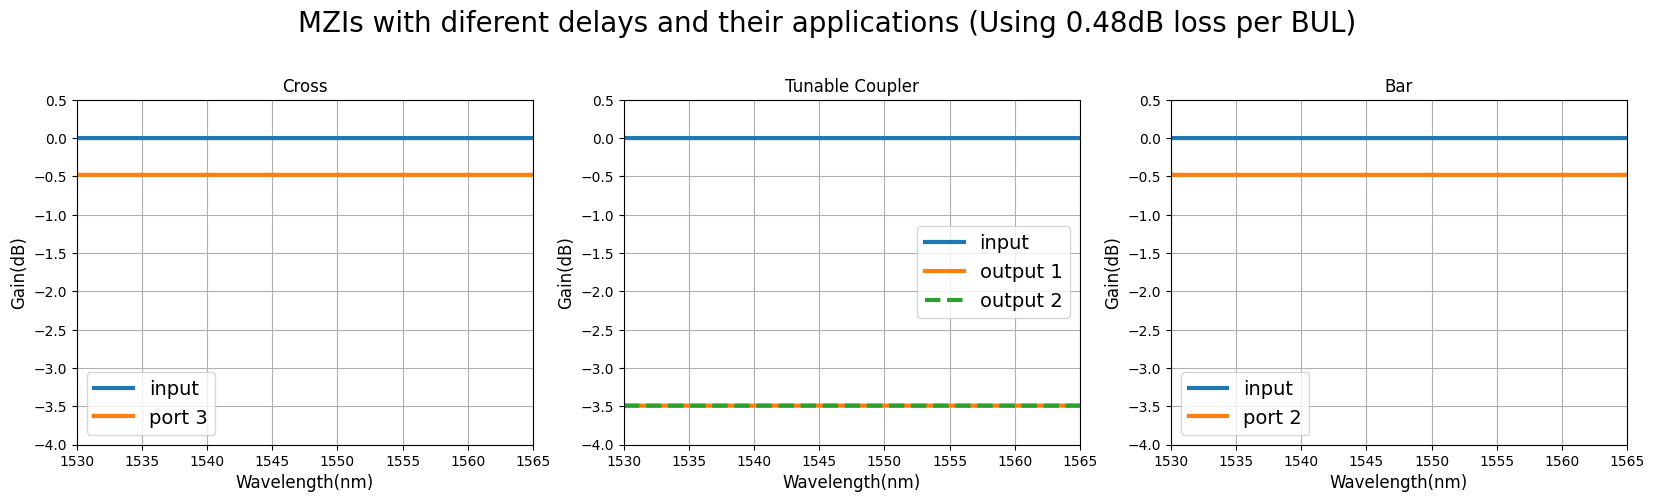

In [10]:
figure1,fig = plt.subplots(1,3,figsize=[20,5]);

gaincross = inter.getresult('ONA_1','input 3/mode 1/gain')['TE gain (dB)']
gainTC1 = inter.getresult('ONA_2','input 2/mode 1/gain')['TE gain (dB)']
gainTC2 = inter.getresult('ONA_2','input 3/mode 1/gain')['TE gain (dB)']
gainbar = inter.getresult('ONA_3','input 2/mode 1/gain')['TE gain (dB)']

λ = np.linspace(simulation_band[0]*1e9,simulation_band[-1]*1e9, points)
input = np.zeros(len(λ))

figure1.suptitle('MZIs with diferent delays and their applications (Using 0.48dB loss per BUL)', fontsize = 20)
figure1.subplots_adjust(top=0.8)

fig[0].set_title('Cross')
fig[0].grid()
fig[0].plot(λ, input, label= 'input', linewidth = 3)
fig[0].plot(λ, gaincross, label = 'port 3', linewidth = 3)
fig[0].legend(fontsize = 14)
fig[0].set_xlim(cband[0]*1e9,cband[-1]*1e9)
fig[0].set_ylim(-4,0.5)
fig[0].set_ylabel('Gain(dB)', fontsize=12)
fig[0].set_xlabel('Wavelength(nm)', fontsize=12)

fig[1].set_title('Tunable Coupler')
fig[1].grid()
fig[1].plot(λ, input, label= 'input', linewidth = 3)
fig[1].plot(λ, gainTC1, label = 'output 1', linewidth = 3)
fig[1].plot(λ, gainTC1,'--', label = 'output 2', linewidth = 3)
fig[1].legend(fontsize = 14)
fig[1].set_xlim(cband[0]*1e9,cband[-1]*1e9)
fig[1].set_ylim(-4,0.5)
fig[1].set_ylabel('Gain(dB)', fontsize=12)
fig[1].set_xlabel('Wavelength(nm)', fontsize=12)

fig[2].set_title('Bar')
fig[2].grid()
fig[2].plot(λ, input, label= 'input', linewidth = 3)
fig[2].plot(λ, gaincross, label = 'port 2', linewidth = 3)
fig[2].legend(fontsize = 14)
fig[2].set_xlim(cband[0]*1e9,cband[-1]*1e9)
fig[2].set_ylim(-4,0.5)
fig[2].set_ylabel('Gain(dB)', fontsize=12)
fig[2].set_xlabel('Wavelength(nm)', fontsize=12);

# Creating an UMZI filter

In [5]:
# Initializing INTERCONNECT
inter = lumapi.INTERCONNECT()

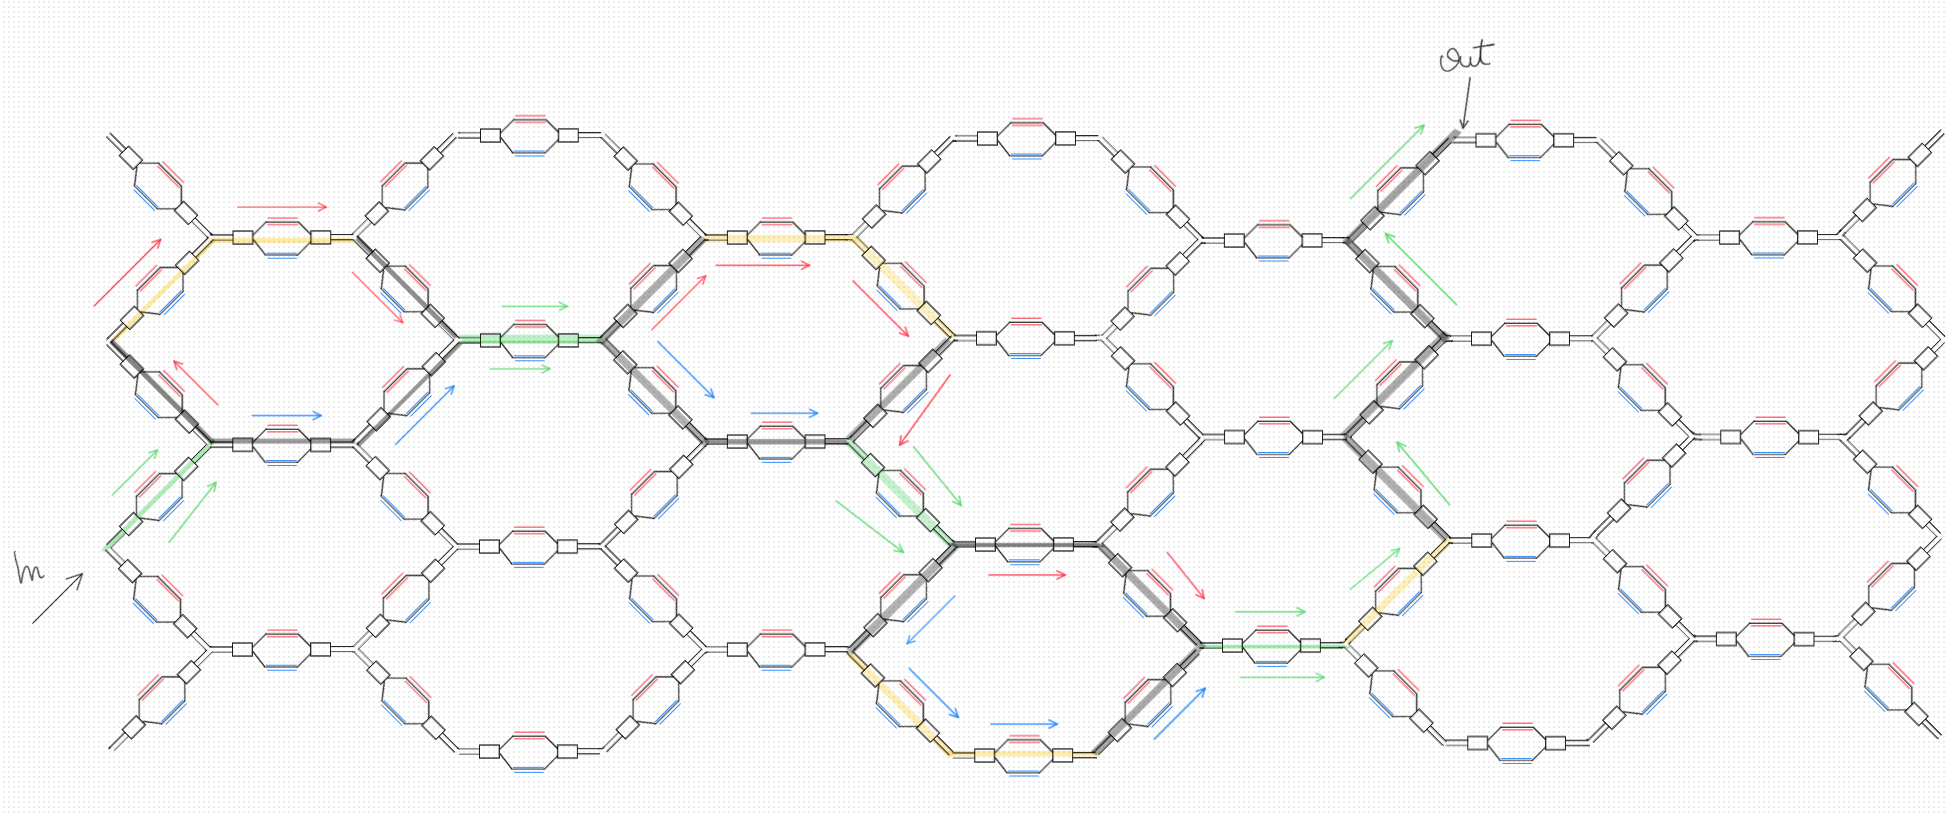

In [6]:
display(Image(filename='../Media/Ilustration/UMZI.png', width=1500))

### With loss

In [109]:
# Unitary UMZI cell
bar = 1
cross = 1
tc = 1
component_name = 'MZI_WITH_LOSS'
loss = 0.48

inter.switchtolayout()
inter.selectall()
inter.delete()

# Create the MZIs

inter.addelement(component_name)
inter.set({'x position':-200,'y position':800,'name': 'TC_'+str(tc),'loss': loss,'Theta 1' : π/2});tc+=1

inter.copy()
inter.set({'x position':300,'y position':600,'name': 'cross_'+str(cross),'Theta 1' : 0});cross+=1

inter.copy()
inter.set({'x position':600,'y position':500,'name': 'cross_'+str(cross),'Theta 1' : 0});cross+=1

inter.copy()
inter.set({'x position':600,'y position':300,'name': 'cross_'+str(cross),'Theta 1' : 0});cross+=1

inter.copy()
inter.set({'x position':300,'y position':100,'name': 'bar_'+str(bar), 'Theta 1' : π});bar+=1

inter.copy()
inter.set({'x position':0,'y position':300,'name': 'bar_'+str(bar), 'Theta 1' : π});bar+=1

inter.copy()
inter.set({'x position':0,'y position':500,'name': 'cross_'+str(cross),'Theta 1' : 0});cross+=1

inter.copy()
inter.set({'x position':900,'y position':400,'name': 'TC_'+str(tc),'Theta 1' : π/2});tc+=1

# Connect the MZIs

Connectcomponents(inter,'TC_1',[4],'cross_1', [2])
Connectcomponents(inter,'cross_1', [3], 'cross_2', [1])
Connectcomponents(inter,'cross_2', [4], 'TC_2', [2])
Connectcomponents(inter,'cross_3', [3], 'TC_2', [1])
Connectcomponents(inter,'cross_3', [2], 'bar_1', [4])
Connectcomponents(inter,'bar_2', [4], 'bar_1', [2])
Connectcomponents(inter,'bar_2', [2], 'cross_4', [1])
Connectcomponents(inter,'cross_4', [4], 'TC_1', [3])
Connectcomponents(inter,'cross_4', [3], 'cross_1', [1])
Connectcomponents(inter,'cross_2', [3], 'cross_3', [4])

# Create the ONA
ports = 4
points = 10001
addONA(inter, simulation_band[0],simulation_band[1],points,ports,-250, 0)

inter.connect('ONA_1', 'output', 'TC_1', 'port 1')
inter.connect('ONA_1', 'input 1', 'TC_2', 'port 3')
inter.connect('ONA_1', 'input 2', 'TC_2', 'port 4')
inter.connect('ONA_1', 'input 3', 'cross_3', 'port 3')
inter.connect('ONA_1', 'input 4', 'cross_2', 'port 4');

inter.run()

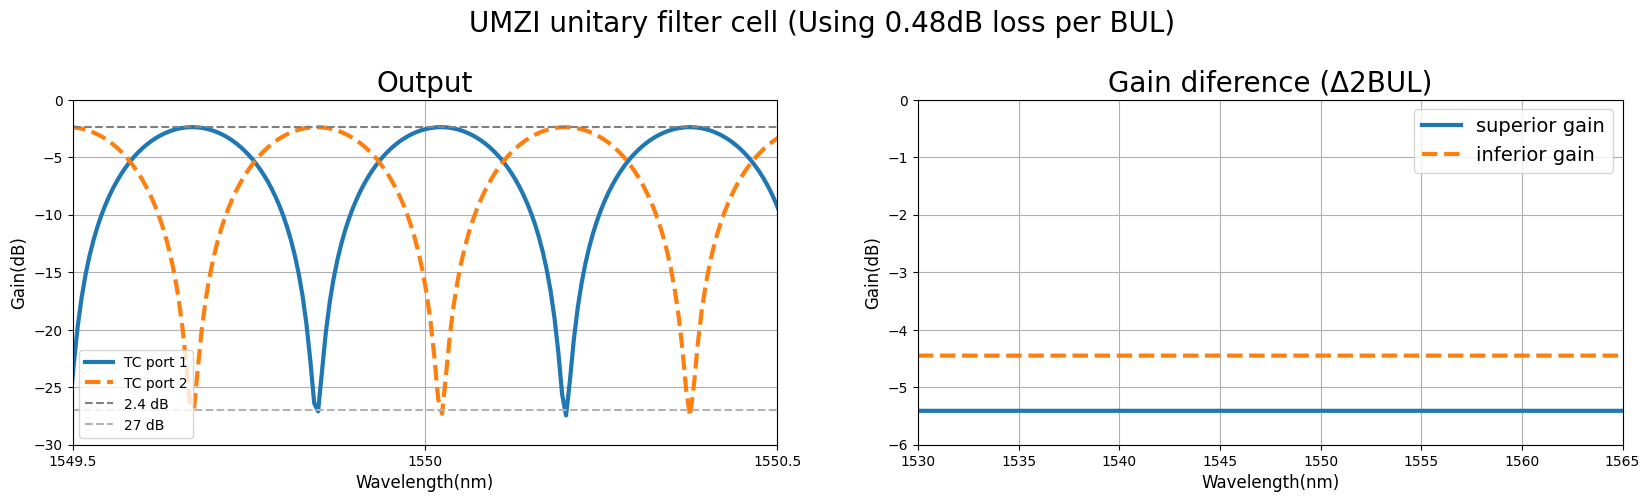

In [110]:
figure2,fig = plt.subplots(1,2,figsize=[20,5]);

gainTC_2p3 = inter.getresult('ONA_1','input 1/mode 1/gain')['TE gain (dB)']
gainTC_2p4 = inter.getresult('ONA_1','input 2/mode 1/gain')['TE gain (dB)']
gaincross_3p3 = inter.getresult('ONA_1','input 3/mode 1/gain')['TE gain (dB)']
gaincross_2p4 = inter.getresult('ONA_1','input 4/mode 1/gain')['TE gain (dB)']

λ = np.linspace(simulation_band[0]*1e9,simulation_band[-1]*1e9, points)

figure2.suptitle('UMZI unitary filter cell (Using 0.48dB loss per BUL)', fontsize = 20)
figure2.subplots_adjust(top=0.8)

fig[0].set_title('Output', fontsize = 20)
fig[0].grid()
fig[0].plot(λ, gainTC_2p3, label= 'TC port 1', linewidth = 3)
fig[0].plot(λ, gainTC_2p4,'--', label = 'TC port 2', linewidth = 3)
fig[0].axhline(-2.4, label = '2.4 dB', color = 'grey', linestyle='--')
fig[0].axhline(-27, label = '27 dB', color = '0.7', linestyle='--')
fig[0].legend(fontsize = 10)
fig[0].set_xlim(1549.5,1550.5)
fig[0].set_ylim(-30,0)
fig[0].set_xticks([1549.5, 1550, 1550.5], ['1549.5', '1550', '1550.5'])
fig[0].set_ylabel('Gain(dB)', fontsize=12)
fig[0].set_xlabel('Wavelength(nm)', fontsize=12)

fig[1].set_title('Gain diference (Δ2BUL)', fontsize = 20)
fig[1].grid()
fig[1].plot(λ, gaincross_3p3, label = 'superior gain', linewidth = 3)
fig[1].plot(λ, gaincross_2p4,'--', label = 'inferior gain', linewidth = 3)
fig[1].legend(fontsize = 14)
fig[1].set_xlim(cband[0]*1e9,cband[-1]*1e9)
fig[1].set_ylim(-6,0)
fig[1].set_ylabel('Gain(dB)', fontsize=12)
fig[1].set_xlabel('Wavelength(nm)', fontsize=12)

figure2.savefig('../Media/UMZI Results/UMZI_unitary_cell_grain.png',bbox_inches='tight')

Text(0.5, 0, 'Wavelength(nm)')

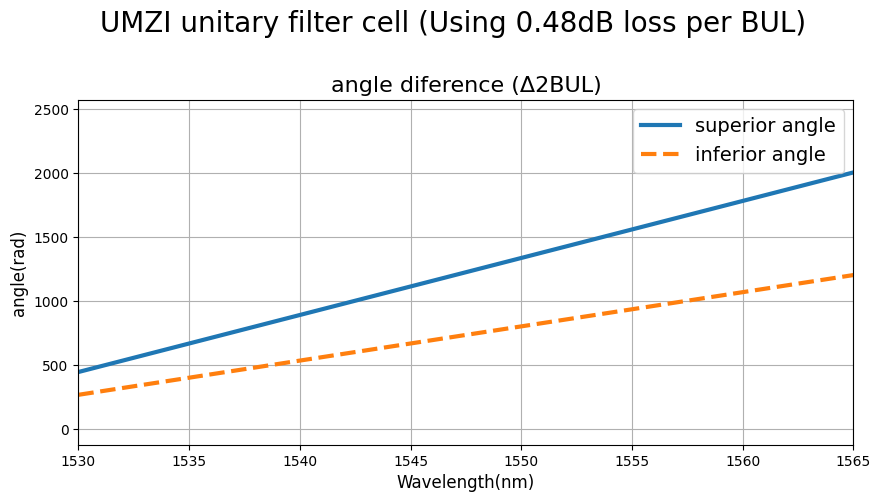

In [10]:
# Plot phase

figure3= plt.figure(figsize=[10,5]);

angleTC_2p3 = inter.getresult('ONA_1','input 1/mode 1/angle')['TE angle (rad)']
angleTC_2p4 = inter.getresult('ONA_1','input 2/mode 1/angle')['TE angle (rad)']
anglecross_3p3 = inter.getresult('ONA_1','input 3/mode 1/angle')['TE angle (rad)']
anglecross_2p4 = inter.getresult('ONA_1','input 4/mode 1/angle')['TE angle (rad)']

λ = np.linspace(simulation_band[0]*1e9,simulation_band[-1]*1e9, points)

figure3.suptitle('UMZI unitary filter cell (Using 0.48dB loss per BUL)', fontsize = 20)
figure3.subplots_adjust(top=0.8)

plt.title('angle diference (Δ2BUL)', fontsize = 16)
plt.grid()
plt.plot(λ, anglecross_3p3, label = 'superior angle', linewidth = 3)
plt.plot(λ, anglecross_2p4,'--', label = 'inferior angle', linewidth = 3)
plt.legend(fontsize = 14)
plt.xlim(cband[0]*1e9,cband[-1]*1e9)
plt.ylabel('angle(rad)', fontsize=12)
plt.xlabel('Wavelength(nm)', fontsize=12)

In [107]:
# Unitary UMZI cell
bar = 1
cross = 1
tc = 1
component_name = 'MZI_WITH_LOSS'
loss = 0.48

inter.switchtolayout()
inter.selectall()
inter.delete()

# Create the MZIs

inter.addelement(component_name)
inter.set({'x position':-200,'y position':800,'name': 'TC_'+str(tc),'loss': loss,'Theta 1' : π/2});tc+=1

inter.copy()
inter.set({'x position':300,'y position':600,'name': 'cross_'+str(cross),'Theta 1' : 0});cross+=1

inter.copy()
inter.set({'x position':600,'y position':500,'name': 'cross_'+str(cross),'Theta 1' : 0});cross+=1

inter.copy()
inter.set({'x position':600,'y position':300,'name': 'cross_'+str(cross),'Theta 1' : 0});cross+=1

inter.copy()
inter.set({'x position':300,'y position':100,'name': 'bar_'+str(bar), 'Theta 1' : π});bar+=1

inter.copy()
inter.set({'x position':0,'y position':300,'name': 'bar_'+str(bar), 'Theta 1' : π});bar+=1

inter.copy()
inter.set({'x position':0,'y position':500,'name': 'cross_'+str(cross),'Theta 1' : 0});cross+=1

inter.copy()
inter.set({'x position':900,'y position':400,'name': 'TC_'+str(tc),'Theta 1' : π/2});tc+=1


# Connect the MZIs

Connectcomponents(inter,'TC_1',[4],'cross_1', [2])
Connectcomponents(inter,'cross_1', [3], 'cross_2', [1])
Connectcomponents(inter,'cross_2', [4], 'TC_2', [2])
Connectcomponents(inter,'cross_3', [3], 'TC_2', [1])
Connectcomponents(inter,'cross_3', [2], 'bar_1', [4])
Connectcomponents(inter,'bar_2', [4], 'bar_1', [2])
Connectcomponents(inter,'bar_2', [2], 'cross_4', [1])
Connectcomponents(inter,'cross_4', [4], 'TC_1', [3])
Connectcomponents(inter,'cross_4', [3], 'cross_1', [1])
Connectcomponents(inter,'cross_2', [3], 'cross_3', [4])

# Create the MZIs


inter.copy()
inter.set({'x position':300+1500,'y position':600,'name': 'cross_'+str(cross),'Theta 1' : 0});cross+=1

inter.copy()
inter.set({'x position':600+1500,'y position':500,'name': 'cross_'+str(cross)});cross+=1

inter.copy()
inter.set({'x position':600+1500,'y position':300,'name': 'bar_'+str(bar), 'Theta 1' : π});bar+=1

inter.copy()
inter.set({'x position':300+1500,'y position':150,'name': 'bar_'+str(bar)});bar+=1

inter.copy()
inter.set({'x position':1500,'y position':300,'name': 'cross_'+str(cross),'Theta 1' : 0});cross+=1

inter.copy()
inter.set({'x position':0+1500,'y position':500,'name': 'cross_'+str(cross),'Theta 1' : 0});cross+=1

inter.copy()
inter.set({'x position':900+1500,'y position':400,'name': 'TC_'+str(tc),'Theta 1' : π/2});tc+=1


# Connect the MZIs

Connectcomponents(inter,'bar_3', [4], 'cross_6', [3])
Connectcomponents(inter,'bar_4', [4], 'bar_3', [2])
Connectcomponents(inter,'bar_4', [2], 'cross_7', [4])
Connectcomponents(inter,'cross_8', [3], 'cross_5', [1])
Connectcomponents(inter,'TC_2', [3], 'cross_7', [1])
Connectcomponents(inter,'TC_2', [4], 'cross_8', [2])
Connectcomponents(inter,'TC_3', [1], 'cross_6', [2])
Connectcomponents(inter,'TC_3',[2],'cross_5', [4])

# Create the ONA
ports = 4
points = 10001
addONA(inter, simulation_band[0],simulation_band[1],points,ports,-250, 0)

inter.connect('ONA_1', 'output', 'TC_1', 'port 1')
inter.connect('ONA_1', 'input 1', 'TC_3', 'port 3')
inter.connect('ONA_1', 'input 2', 'TC_3', 'port 4')
inter.connect('ONA_1', 'input 3', 'cross_5', 'port 4')
inter.connect('ONA_1', 'input 4', 'cross_6', 'port 2');

inter.run()

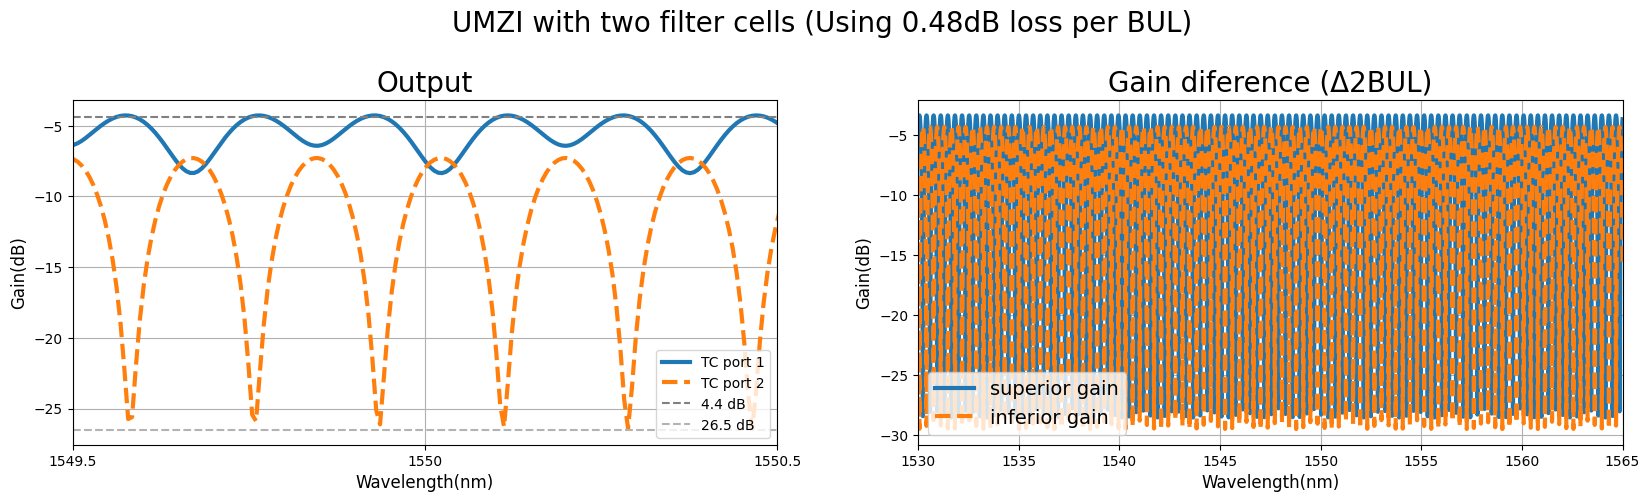

In [108]:
figure4,fig = plt.subplots(1,2,figsize=[20,5]);

gainTC_2p3 = inter.getresult('ONA_1','input 1/mode 1/gain')['TE gain (dB)']
gainTC_2p4 = inter.getresult('ONA_1','input 2/mode 1/gain')['TE gain (dB)']
gaincross_3p3 = inter.getresult('ONA_1','input 3/mode 1/gain')['TE gain (dB)']
gaincross_2p4 = inter.getresult('ONA_1','input 4/mode 1/gain')['TE gain (dB)']

λ = np.linspace(simulation_band[0]*1e9,simulation_band[-1]*1e9, points)

figure4.suptitle('UMZI with two filter cells (Using 0.48dB loss per BUL)', fontsize = 20)
figure4.subplots_adjust(top=0.8)

fig[0].set_title('Output', fontsize = 20)
fig[0].grid()
fig[0].plot(λ, gainTC_2p3, label= 'TC port 1', linewidth = 3)
fig[0].plot(λ, gainTC_2p4,'--', label = 'TC port 2', linewidth = 3)
fig[0].axhline(-4.4, label = '4.4 dB', color = 'grey', linestyle='--')
fig[0].axhline(-26.5, label = '26.5 dB', color = '0.7', linestyle='--')
fig[0].legend(fontsize = 10)
fig[0].set_xlim(1549.5,1550.5)
fig[0].set_xticks([1549.5, 1550, 1550.5], ['1549.5', '1550', '1550.5'])
fig[0].set_ylabel('Gain(dB)', fontsize=12)
fig[0].set_xlabel('Wavelength(nm)', fontsize=12)

fig[1].set_title('Gain diference (Δ2BUL)', fontsize = 20)
fig[1].grid()
fig[1].plot(λ, gaincross_3p3, label = 'superior gain', linewidth = 3)
fig[1].plot(λ, gaincross_2p4,'--', label = 'inferior gain', linewidth = 3)
fig[1].legend(fontsize = 14)
fig[1].set_xlim(cband[0]*1e9,cband[-1]*1e9)
fig[1].set_ylabel('Gain(dB)', fontsize=12)
fig[1].set_xlabel('Wavelength(nm)', fontsize=12)

figure2.savefig('../Media/UMZI Results/UMZI_2unitary_cells_grain.png',bbox_inches='tight')

### Without Loss

In [11]:
# Unitary UMZI cell
bar = 1
cross = 1
tc = 1
component_name = 'MZI_IDEAL_CELL'

inter.switchtolayout()
inter.selectall()
inter.delete()

# Create the MZIs

inter.addelement(component_name)
inter.set({'x position':-200,'y position':800,'name': 'TC_'+str(tc),'Theta 1' : π/2});tc+=1

inter.copy()
inter.set({'x position':300,'y position':600,'name': 'cross_'+str(cross),'Theta 1' : 0});cross+=1

inter.copy()
inter.set({'x position':600,'y position':500,'name': 'cross_'+str(cross)});cross+=1

inter.copy()
inter.set({'x position':600,'y position':300,'name': 'cross_'+str(cross)});cross+=1

inter.copy()
inter.set({'x position':300,'y position':100,'name': 'bar_'+str(bar), 'Theta 1' : π});bar+=1

inter.copy()
inter.set({'x position':0,'y position':300,'name': 'bar_'+str(bar)});bar+=1

inter.copy()
inter.set({'x position':0,'y position':500,'name': 'cross_'+str(cross),'Theta 1' : 0});cross+=1

inter.copy()
inter.set({'x position':900,'y position':400,'name': 'TC_'+str(tc),'Theta 1' : π/2});tc+=1

# Connect the MZIs

Connectcomponents(inter,'TC_1',[4],'cross_1', [2])
Connectcomponents(inter,'cross_1', [3], 'cross_2', [1])
Connectcomponents(inter,'cross_2', [4], 'TC_2', [2])
Connectcomponents(inter,'cross_3', [3], 'TC_2', [1])
Connectcomponents(inter,'cross_3', [2], 'bar_1', [4])
Connectcomponents(inter,'bar_2', [4], 'bar_1', [2])
Connectcomponents(inter,'bar_2', [2], 'cross_4', [1])
Connectcomponents(inter,'cross_4', [4], 'TC_1', [3])
Connectcomponents(inter,'cross_4', [3], 'cross_1', [1])
Connectcomponents(inter,'cross_2', [3], 'cross_3', [4])

# Create the ONA
ports = 4
points = 10001
addONA(inter, simulation_band[0],simulation_band[1],points,ports,-250, 0)

inter.connect('ONA_1', 'output', 'TC_1', 'port 1')
inter.connect('ONA_1', 'input 1', 'TC_2', 'port 3')
inter.connect('ONA_1', 'input 2', 'TC_2', 'port 4')
inter.connect('ONA_1', 'input 3', 'cross_3', 'port 3')
inter.connect('ONA_1', 'input 4', 'cross_2', 'port 4');

inter.run()

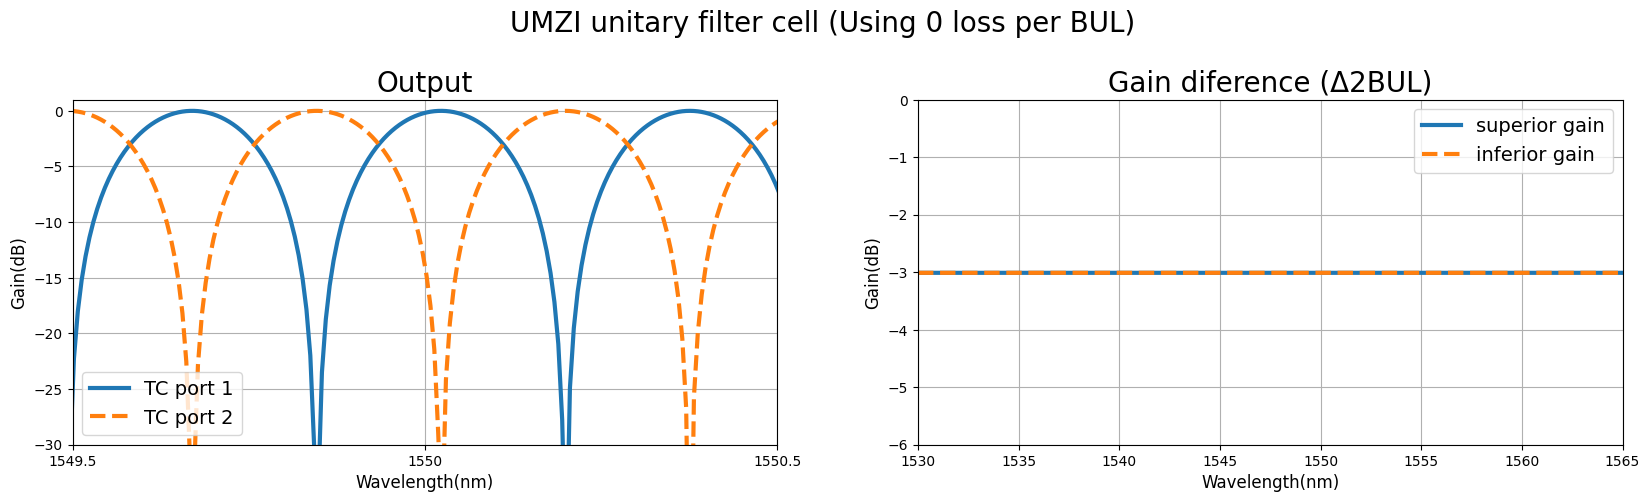

In [12]:
figure4,fig = plt.subplots(1,2,figsize=[20,5]);

gainTC_2p3 = inter.getresult('ONA_1','input 1/mode 1/gain')['TE gain (dB)']
gainTC_2p4 = inter.getresult('ONA_1','input 2/mode 1/gain')['TE gain (dB)']
gaincross_3p3 = inter.getresult('ONA_1','input 3/mode 1/gain')['TE gain (dB)']
gaincross_2p4 = inter.getresult('ONA_1','input 4/mode 1/gain')['TE gain (dB)']

λ = np.linspace(simulation_band[0]*1e9,simulation_band[-1]*1e9, points)

figure4.suptitle('UMZI unitary filter cell (Using 0 loss per BUL)', fontsize = 20)
figure4.subplots_adjust(top=0.8)

fig[0].set_title('Output', fontsize = 20)
fig[0].grid()
fig[0].plot(λ, gainTC_2p3, label= 'TC port 1', linewidth = 3)
fig[0].plot(λ, gainTC_2p4,'--', label = 'TC port 2', linewidth = 3)

fig[0].legend(fontsize = 14)
fig[0].set_xlim(1549.5,1550.5)
fig[0].set_ylim(-30,1)
fig[0].set_xticks([1549.5, 1550, 1550.5], ['1549.5', '1550', '1550.5'])
fig[0].set_ylabel('Gain(dB)', fontsize=12)
fig[0].set_xlabel('Wavelength(nm)', fontsize=12)

fig[1].set_title('Gain diference (Δ2BUL)', fontsize = 20)
fig[1].grid()
fig[1].plot(λ, gaincross_3p3, label = 'superior gain', linewidth = 3)
fig[1].plot(λ, gaincross_2p4,'--', label = 'inferior gain', linewidth = 3)
fig[1].legend(fontsize = 14)
fig[1].set_xlim(cband[0]*1e9,cband[-1]*1e9)
fig[1].set_ylim(-6,0)
fig[1].set_ylabel('Gain(dB)', fontsize=12)
fig[1].set_xlabel('Wavelength(nm)', fontsize=12)

figure4.savefig('../Media/UMZI Results/UMZI_unitary_cell_grain_ideal.png',bbox_inches='tight')